## Аналитика данных. Домашнее задание 3 (HW)

### Задачи:
Нужно проанализировать биоинформатический датасет (ссылка на скачивание) по пространственной транскриптомике (дополнительная информация по теме) пациентов с плоскоклеточным раком. В нем клетки (колонка cell_type) объединены в микроокружения (колонка cell_interaction) в зависимости от взаимодействия этих клеток. 

Основная задача -- поиск отличий в организации микроокружения у пожилых и молодых пациентов (колонка age_group).

Также в датасете есть следующие колонки:

* distance_to_vasculature — расстояние до ближайших сосудов;
* distance_to_largest_cell — расстояние до ближайшей крупной клетки;
* immune_marker_1 — экспрессия иммунного маркера 1 в данной клетке;
* immune_marker_2 — экспрессия иммунного маркера 2 в данной клетке;
* cell_type — тип клетки;
* area_of_cell — размер клетки;
* case_id — уникальный ID пациента.


#### Необходимо:

В ноутбуке проанализировать датасет и сделать статистически обоснованные выводы.

In [1]:
!pip install researchpy

In [2]:
#импорт данных
data_link = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('asset-v1_SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv')
data.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269442 entries, 0 to 269441
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   269442 non-null  float64
 1   distance_to_largest_cell  269442 non-null  float64
 2   immune_marker_1           269442 non-null  float64
 3   immune_marker_2           269442 non-null  float64
 4   cell_interaction          269442 non-null  object 
 5   cell_type                 269442 non-null  object 
 6   case_id                   269442 non-null  int64  
 7   area_of_cell              269442 non-null  int64  
 8   age_group                 269442 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 18.5+ MB


### Пропущенных значений нет, перейдем к анализу

## Задача 1

Есть ли стат-значимость между типом клетки и:

    а) Размером клетки (area_of_cell), добавьте hue по возрастным группам.
    б) Экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.
    в) Дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.


In [6]:
# Для начала визуализируем распределение каждой переменной по типам клеток с учетом возрастных групп.

# Определим функцию построения графиков:

def boxplot_data(data, x, y, hue):
    """
    Функция для построения и отображения графиков seaborn.
    :param data: DataFrame для анализа.
    :param x: колонка для оси X.
    :param y: колонка для оси Y.
    :param hue: параметр для разделения данных по цветам.
    """
    # Настройка размера графиков
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x, y=y, hue=hue, data=data, palette="Set3")
    plt.title(f'Распределение {y} по {x} с разделением по {hue}')
    plt.xticks(rotation=90)
    plt.show()

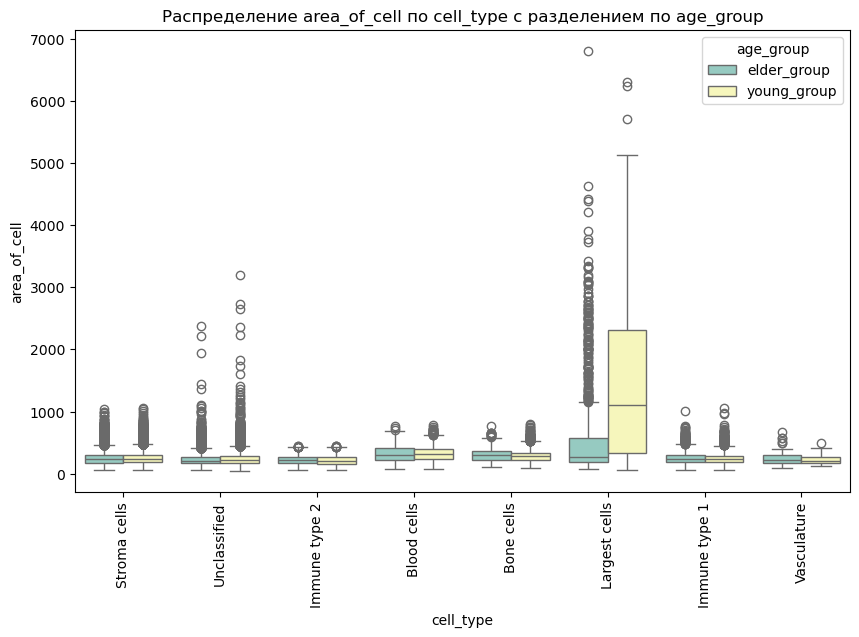

In [7]:
# Визуализация
boxplot_data(data, x='cell_type', y='area_of_cell', hue='age_group')

На графике показано распределение размера клеток (area_of_cell) по различным типам клеток с разделением по возрастным группам. Это дает нам визуальное представление о возможных различиях в размере клеток между разными типами клеток, а также о влиянии возрастной группы на эти параметры.

Необходимо отметить, что визуально определяется значительная доля выбросов в данных, которые могут влиять на результаты анализа, особенно в случае редких типов клеток или необычных микроокружений. Во-вторых, методика группировки по возрасту может вносить дополнительную вариабельность, поскольку не учитывает индивидуальные различия в состоянии здоровья или стадии заболевания. В-третьих, размер выборки и способ ее формирования могут ограничивать обобщаемость наших выводов на более широкую популяцию. Для минимизации влияния выбросов будем использовать робастные статичтисеские методы. В качестве альтернативы было бы хорошо проанализировать случаи, вызывающие выбросы, чтобы определить, стоит ли их исключать из анализа на уровне выборки.

## Проведем статистический анализ для определения наличия статистически значимых различий.

Для анализа статистической значимости различий в размерах клеток между типами клеток в разных возрастных группах, мы можем использовать ANOVA тест, если выполняется нормальное распределение внутри групп и гомогенность дисперсий, или непараметрический аналог, если данные не соответствуют этим условиям.

In [8]:
# Проверим данные на нормальность с помощью теста Шапиро-Уилка и на гомогенность дисперсий с помощью теста Левена.

from scipy.stats import shapiro, levene

# Определим функцию для проведения тестов на нормальность и гомогенность диспресий.

def normality_disperse_test(data, x, y, hue):
    samples = [data[(data[x] == cell_type) & (data[hue] == age_group)][y]
               for cell_type in data[x].unique()
               for age_group in data[hue].unique()]
    
    # Проверка на нормальность
    normality_results = [shapiro(sample) for sample in samples if len(sample) < 5000]  # Ограничение теста

    # Проверка гомогенности дисперсий
    levene_test = levene(*samples)

    return normality_results, levene_test

# Проверим данные
normality_disperse_test(data, 'cell_type', 'area_of_cell', 'age_group')

([ShapiroResult(statistic=0.9638803402718071, pvalue=5.183274899268574e-10),
  ShapiroResult(statistic=0.9703028158298469, pvalue=2.106969845761151e-21),
  ShapiroResult(statistic=0.9468906006239348, pvalue=1.244843868473269e-10),
  ShapiroResult(statistic=0.9347461567102503, pvalue=8.519691807548451e-30),
  ShapiroResult(statistic=0.6196429777650558, pvalue=3.8383937158409e-40),
  ShapiroResult(statistic=0.8971470609396688, pvalue=1.3345067792777888e-26),
  ShapiroResult(statistic=0.9030004344715256, pvalue=1.4943275935585075e-30),
  ShapiroResult(statistic=0.8988932446221027, pvalue=1.9411505334720356e-45),
  ShapiroResult(statistic=0.8702886993085306, pvalue=1.8598707474972545e-07),
  ShapiroResult(statistic=0.9102333646351616, pvalue=0.0008312354455677698)],
 LeveneResult(statistic=8439.115411919005, pvalue=0.0))

Результаты проверки на нормальность, что p-значения для всех выборок  меньше 0.05, что указывает на отсутствие нормального распределения размеров клеток в каждой из подгрупп. Тест Левена на гомогенность дисперсий также показывает, что дисперсии между группами статистически значимо различаются (p < 0.05).

Эти результаты указывают на то, что данные не соответствуют условиям для применения ANOVA. Тогда используем непараметрический аналог —  тест Краскела-Уоллиса, чтобы сравнить размеры клеток между различными типами клеток и возрастными группами.

Проведем тест Краскела-Уоллиса для каждого типа клетки, сравнивая различные возрастные группы

In [11]:
from scipy.stats import kruskal

# Определим функцию для проведения теста Краскера-Уоллиса

def kruskal_test(data, x, y, hue):
    # Словарь для результатов Краскела-Уоллиса теста
    kruskal_results = {}
    
    for cell_type in data[x].unique():
        samples = [data[(data[x] == cell_type) & (data[hue] == age_group)][y]
                   for age_group in data[hue].unique()]
        # Пропускаем тест, если в какой-либо группе меньше 2 наблюдений
        if all(len(sample) > 1 for sample in samples):
            kruskal_test = kruskal(*samples)
            kruskal_results[cell_type] = kruskal_test

    return kruskal_results

# Проведем тест Краскела-Уоллиса 
kruskal_test(data, 'cell_type', 'area_of_cell', 'age_group')

{'Stroma cells': KruskalResult(statistic=485.084501150798, pvalue=1.6725518119512272e-107),
 'Unclassified': KruskalResult(statistic=51.74215418952049, pvalue=6.328922569995752e-13),
 'Immune type 2': KruskalResult(statistic=66.75509052845293, pvalue=3.0742252797501433e-16),
 'Blood cells': KruskalResult(statistic=0.0630757996529163, pvalue=0.8016989447315541),
 'Bone cells': KruskalResult(statistic=8.382605375945765, pvalue=0.003788289886284435),
 'Largest cells': KruskalResult(statistic=327.76234627595915, pvalue=2.9522713980296525e-73),
 'Immune type 1': KruskalResult(statistic=12.067920796233116, pvalue=0.0005129687897256492),
 'Vasculature': KruskalResult(statistic=0.13095013824948745, pvalue=0.7174489301074176)}

* Для большинства типов клеток (кроме Blood cells и Vasculature) наблюдаются статистически значимые различия в размерах клеток между возрастными группами (p < 0.05);
* В частности, для Stroma cells, Unclassified, Immune type 2, и Largest cells p-значения настолько малы, что указывают на очень сильные различия в распределении размеров клеток между возрастными группами;
* Для Blood cells и Vasculature типов клеток p-значения выше 0.05, что указывает на отсутствие статистически значимых различий в размерах клеток между возрастными группами.

### Оценим величину эффектов

Важно также учитывать величину эффекта, поскольку статистическая значимость не всегда соответствует практической значимости различий.

Чтобы оценить величину эффекта на основе результатов теста Краскела-Уоллиса для исследования, рассчитаем Eta-квадрат для каждой переменной, для которой наблюдаем статистически значимые различия. Это даст количественную оценку того, насколько значительно каждая переменная влияет на общую дисперсию ваших данных.

η² можно рассчитать для теста Краскела-Уоллиса как меру величины эффекта. Формула для его расчета:

$$
\eta^2 = \frac{H - (k - 1)}{N - k}
$$


где 
* H — статистика Краскела-Уоллиса, 
* k — количество групп, 
* N — общее количество наблюдений.

Eta-квадрат измеряет долю общей дисперсии, объясненную групповой переменной.

In [20]:
# Определим функцию расчета Etd-квадрат

def calculate_eta_squared(kruskal_results):

    N = data.shape[0]  # Общее количество наблюдений
    k = 2  # Количество групп, для которых был проведен тест Краскела-Уоллиса
    
    
    eta_squared_results = {}
    
    for cell_type, results in kruskal_results.items():
        H = results.statistic
        eta_squared = (H - (k - 1)) / (N - k)
        eta_squared_results[cell_type] = eta_squared
    
    return eta_squared_results

calculate_eta_squared(kruskal_test(data, 'cell_type', 'area_of_cell', 'age_group'))

{'Stroma cells': 0.0017966319074777242,
 'Unclassified': 0.00018832450337559565,
 'Immune type 2': 0.00024404353670001827,
 'Blood cells': -3.4773018124520623e-06,
 'Bone cells': 2.7399812113812965e-05,
 'Largest cells': 0.00121274623766315,
 'Immune type 1': 4.107749701689844e-05,
 'Vasculature': -3.225392895451724e-06}

Результаты показывают, что для всех типов клеток значения Eta-квадрата достаточно малы, что указывает на небольшую величину эффекта различий между группами по рассматриваемому параметру.

Наибольшее значение Eta-квадрата наблюдается для "Stroma cells" (0.0018) и "Largest cells" (0.0012), что говорит о небольшом, но наиболее заметном влиянии типа клетки на изучаемый параметр среди всех рассмотренных типов клеток.

Отрицательные значения Eta-квадрата, скорее всего, являются результатом округления ошибок и должны интерпретироваться как нулевые или очень маленькие значения, указывающие на отсутствие влияния типа клетки на параметры.

Важно также учитывать p-значения теста Краскела-Уоллиса, которые указывают на статистическую значимость обнаруженных различий. Сочетание малых значений Eta-квадрата с низкими p-значениями может свидетельствовать о том, что, хотя статистически значимые различия присутствуют, их практическая значимость может быть ограничена.

В целом, результаты анализа предполагают, что, несмотря на наличие статистически значимых различий между некоторыми группами клеток, величина эффекта этих различий в целом мала.

## Проведем аналогичный анализ для экспрессии имунных маркеров

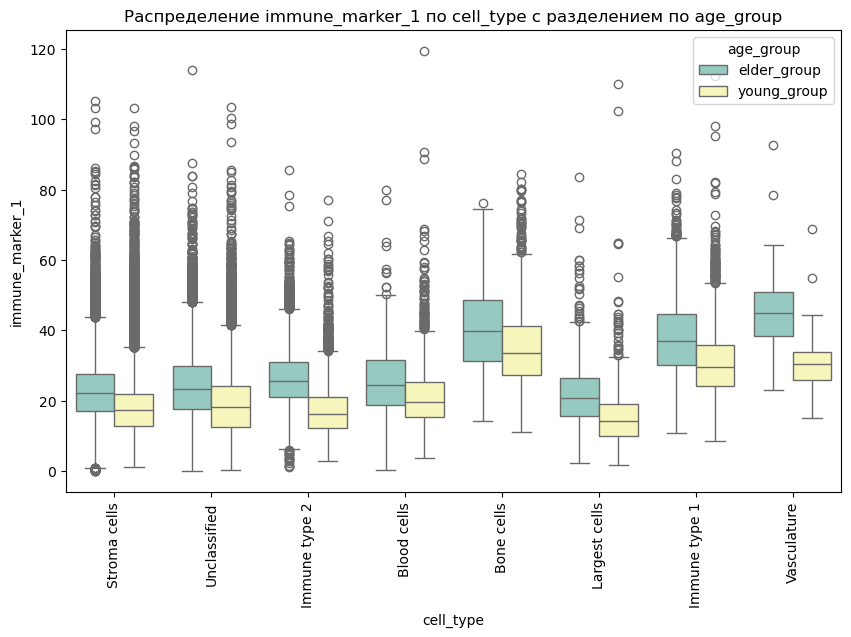

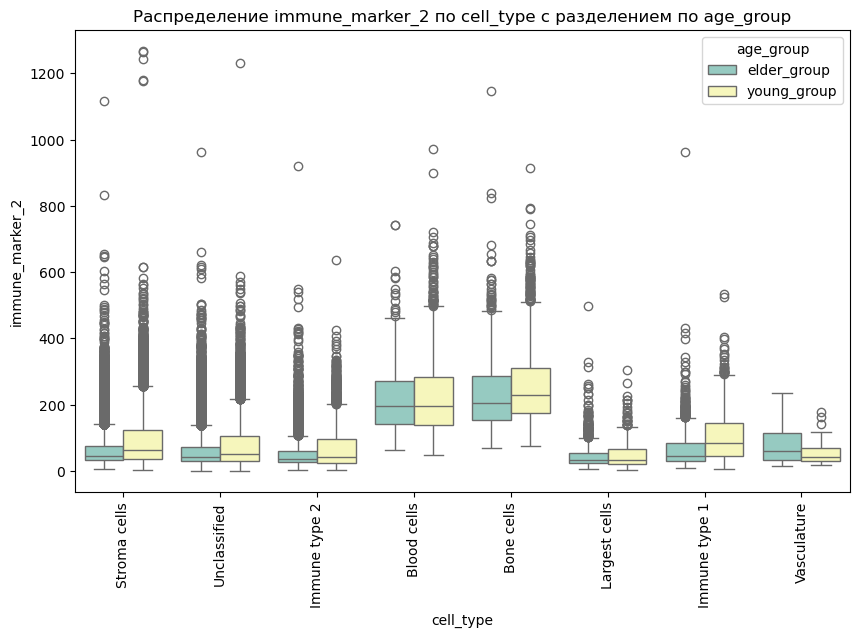

In [8]:
# Визуализация
boxplot_data(data, x='cell_type', y='immune_marker_1', hue='age_group')
boxplot_data(data, x='cell_type', y='immune_marker_2', hue='age_group')

На графиках представлена визуализация экспрессии иммунных маркеров 1 и 2 по типам клеток с разделением по возрастным группам. Эти графики позволяют визуально оценить различия в уровнях экспрессии маркеров между разными типами клеток и возрастными группами.

Теперь проведем статистический анализ для определения наличия статистически значимых различий в экспрессии иммунных маркеров между типами клеток в разных возрастных группах. Учитывая предыдущие результаты тестов на нормальность и гомогенность дисперсий, мы продолжим использовать непараметрический тест Краскела-Уоллиса.

In [9]:
# Проведем тест Краскела-Уоллиса 
kruskal_test(data, 'cell_type', 'immune_marker_1', 'age_group')

{'Stroma cells': KruskalResult(statistic=13098.31611082594, pvalue=0.0),
 'Unclassified': KruskalResult(statistic=4934.931297609051, pvalue=0.0),
 'Immune type 2': KruskalResult(statistic=5095.50181617559, pvalue=0.0),
 'Blood cells': KruskalResult(statistic=117.91952042664128, pvalue=1.8056797201268765e-27),
 'Bone cells': KruskalResult(statistic=72.17146795654624, pvalue=1.9728772543745173e-17),
 'Largest cells': KruskalResult(statistic=339.47456589407454, pvalue=8.304262271507349e-76),
 'Immune type 1': KruskalResult(statistic=569.3579998397548, pvalue=7.744067153278382e-126),
 'Vasculature': KruskalResult(statistic=59.078030215661386, pvalue=1.515417956543255e-14)}

In [10]:
kruskal_test(data, 'cell_type', 'immune_marker_2', 'age_group')

{'Stroma cells': KruskalResult(statistic=4079.329626977957, pvalue=0.0),
 'Unclassified': KruskalResult(statistic=393.78741289033127, pvalue=1.2398323559885132e-87),
 'Immune type 2': KruskalResult(statistic=38.67761279254942, pvalue=4.999100708526236e-10),
 'Blood cells': KruskalResult(statistic=0.04600950714081011, pvalue=0.8301585171693324),
 'Bone cells': KruskalResult(statistic=13.885192222743163, pvalue=0.0001943234704689618),
 'Largest cells': KruskalResult(statistic=0.4649043778645873, pvalue=0.4953407810463696),
 'Immune type 1': KruskalResult(statistic=436.221661672539, pvalue=7.190618242210395e-97),
 'Vasculature': KruskalResult(statistic=5.739407219467182, pvalue=0.016588390080277366)}

### Оценим величину эффекта

In [21]:
calculate_eta_squared(kruskal_test(data, 'cell_type', 'immune_marker_1', 'age_group'))

{'Stroma cells': 0.0486093976797281,
 'Unclassified': 0.018311799649677298,
 'Immune type 2': 0.018907741301126744,
 'Blood cells': 0.00043393527474258197,
 'Bone cells': 0.00026414588760594656,
 'Largest cells': 0.001256214986245823,
 'Immune type 1': 0.002109404690616667,
 'Vasculature': 0.00021555088411394518}

In [23]:
calculate_eta_squared(kruskal_test(data, 'cell_type', 'immune_marker_2', 'age_group'))

{'Stroma cells': 0.015136318389912251,
 'Unclassified': 0.0014577917639932128,
 'Immune type 2': 0.0001398367458155783,
 'Blood cells': -3.5406416748040005e-06,
 'Bone cells': 4.782212077918335e-05,
 'Largest cells': -1.985954654599958e-06,
 'Immune type 1': 0.0016152822953998628,
 'Vasculature': 1.75898427088301e-05}

Результаты теста Краскела-Уоллиса для экспрессии иммунных маркеров 1 и 2 (immune_marker_1 и immune_marker_2) показывают следующее:

* Для immune_marker_1: Во всех типах клеток, кроме Blood cells и Vasculature для immune_marker_2, наблюдаются статистически значимые различия в экспрессии между возрастными группами (p < 0.05). Особенно значительные различия для типов Stroma cells, Unclassified, и Immune type 2.
* Для immune_marker_2: Значимые различия также присутствуют в большинстве типов клеток, за исключением Blood cells, Largest cells, и Vasculature, где p-значения указывают на отсутствие статистически значимых различий между возрастными группами.

Эти результаты подтверждают наличие значимых различий в экспрессии иммунных маркеров между возрастными группами для большинства типов клеток.


* Для иммунного маркера 1, наибольшее значение Eta-квадрата наблюдается для "Stroma cells" (0.0486), что свидетельствует о наиболее заметном влиянии типа клетки на уровень экспрессии этого маркера. Однако даже это наибольшее значение указывает лишь на умеренное влияние.

* Для иммунного маркера 2, наибольшее значение Eta-квадрата также наблюдается для "Stroma cells" (0.0151), но оно значительно меньше по сравнению с маркером 1. Это указывает на то, что влияние типа клетки на уровень экспрессии второго маркера менее выражено.

Отрицательные значения Eta-квадрата для некоторых типов клеток при анализе иммунного маркера 2, скорее всего, являются результатом округления или вычислительных погрешностей и должны интерпретироваться как нулевые или очень малые значения, указывающие на отсутствие влияния.

## Таким образом,

* Влияние на иммунный маркер 1 более выражено, чем на иммунный маркер 2, с наибольшим эффектом, наблюдаемым для стромальных клеток.
* Оба маркера показывают умеренное или слабое влияние типа клетки и возрастной группы на их уровни экспрессии, с наибольшим влиянием на стромальные клетки.

Эти результаты подчеркивают важность типа клетки в регуляции уровня экспрессии иммунных маркеров, но также указывают на то, что другие факторы могут играть роль в этом процессе, учитывая относительно низкую величину эффекта.


## Проведем аналогичный анализ для дистанции до ближайших объектов

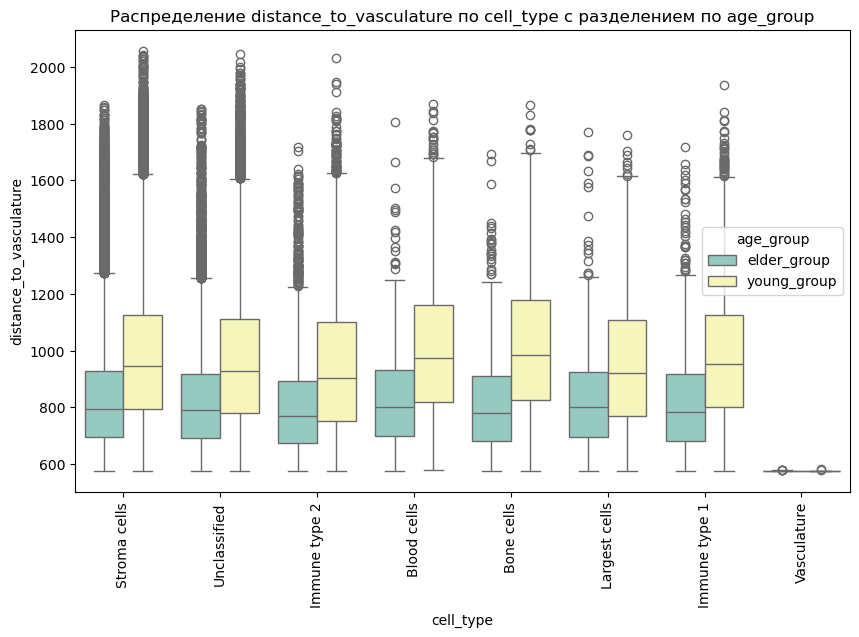

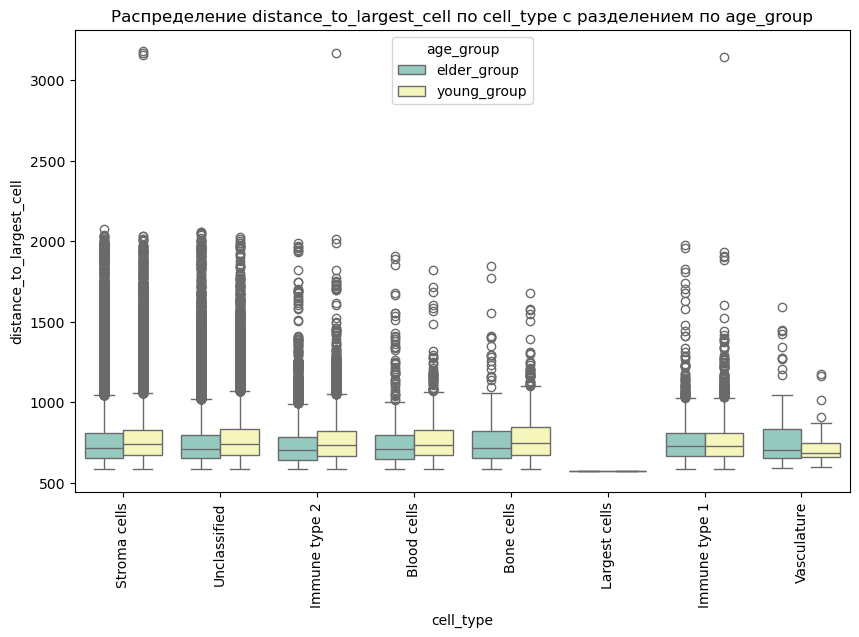

In [11]:
# Визуализация
boxplot_data(data, x='cell_type', y='distance_to_vasculature', hue='age_group')
boxplot_data(data, x='cell_type', y='distance_to_largest_cell', hue='age_group')

In [12]:
# Проведем тест Краскела-Уоллиса 
kruskal_test(data, 'cell_type', 'distance_to_vasculature', 'age_group')

{'Stroma cells': KruskalResult(statistic=14956.22487014148, pvalue=0.0),
 'Unclassified': KruskalResult(statistic=6045.996541779459, pvalue=0.0),
 'Immune type 2': KruskalResult(statistic=1518.0792855714462, pvalue=0.0),
 'Blood cells': KruskalResult(statistic=233.67565552671476, pvalue=9.413917594004068e-53),
 'Bone cells': KruskalResult(statistic=209.1300461560113, pvalue=2.1265074512275832e-47),
 'Largest cells': KruskalResult(statistic=155.97741434947602, pvalue=8.562546860055077e-36),
 'Immune type 1': KruskalResult(statistic=599.3548757889475, pvalue=2.3126973687393413e-132),
 'Vasculature': KruskalResult(statistic=2.0949832775918935, pvalue=0.1477833285998148)}

In [13]:
kruskal_test(data, 'cell_type', 'distance_to_largest_cell', 'age_group')

{'Stroma cells': KruskalResult(statistic=1095.7822949873516, pvalue=2.7263427227421726e-240),
 'Unclassified': KruskalResult(statistic=1012.3011456377571, pvalue=3.8058918867435395e-222),
 'Immune type 2': KruskalResult(statistic=330.7216194088396, pvalue=6.692959547992128e-74),
 'Blood cells': KruskalResult(statistic=22.492910536775526, pvalue=2.109205999148913e-06),
 'Bone cells': KruskalResult(statistic=15.454069701722801, pvalue=8.453471592890127e-05),
 'Largest cells': KruskalResult(statistic=0.013237860225672193, pvalue=0.9084008140485378),
 'Immune type 1': KruskalResult(statistic=0.02115728296485031, pvalue=0.8843513008366265),
 'Vasculature': KruskalResult(statistic=1.298742936224187, pvalue=0.2544429684704008)}

### Оценим величину эффекта

In [24]:
calculate_eta_squared(kruskal_test(data, 'cell_type', 'distance_to_vasculature', 'age_group'))

{'Stroma cells': 0.05550484289690276,
 'Unclassified': 0.022435408780357255,
 'Immune type 2': 0.005630490222578111,
 'Blood cells': 0.0008635527595261089,
 'Bone cells': 0.000772454149925814,
 'Largest cells': 0.0005751833964870696,
 'Immune type 1': 0.002220735138765393,
 'Vasculature': 4.063922497000793e-06}

In [25]:
calculate_eta_squared(kruskal_test(data, 'cell_type', 'distance_to_largest_cell', 'age_group'))

{'Stroma cells': 0.00406317656987586,
 'Unclassified': 0.003753344513204265,
 'Immune type 2': 0.001223729288186014,
 'Blood cells': 7.976881879741511e-05,
 'Bone cells': 5.3644854890598284e-05,
 'Largest cells': -3.6622704118702785e-06,
 'Immune type 1': -3.6328782550295047e-06,
 'Vasculature': 1.1087549592643516e-06}

Результаты теста Краскела-Уоллиса для дистанции до ближайших сосудов (`distance_to_vasculature`) и до ближайшей крупной клетки (`distance_to_largest_cell`) показывают следующее:

* Для distance_to_vasculature:
  - В большинстве типов клеток наблюдаются статистически значимые различия между возрастными группами, с p-значениями, равными 0.0, что указывает на очень сильные различия.
  - Исключение составляет тип клеток Vasculature, для которого p-значение равно 0.1477833285998148, что указывает на отсутствие статистически значимых различий в дистанции до ближайших сосудов между возрастными группами.

* Для distance_to_largest_cell:
  - Также наблюдаются значимые различия для большинства типов клеток. Особенно сильные различия наблюдаются для типов Stroma cells и Unclassified с p-значениями практически равными нулю.
  - Для типов Largest cells и Immune type 1, а также Vasculature p-значения значительно выше, что указывает на отсутствие статистически значимых различий в дистанции до ближайшей крупной клетки между возрастными группами.

Эти результаты подчеркивают наличие статистически значимых различий в дистанции до ближайших сосудов и до ближайшей крупной клетки между возрастными группами для большинства типов клеток, что может свидетельствовать о различиях в организации микроокружения у пациентов разного возраста.

#### Расстояние до сосудов:
  
Наибольшее значение Eta-квадрата наблюдается для "Stroma cells" (0.0555), что указывает на значительное влияние типа клетки на расстояние до сосудов. Это может свидетельствовать о том, что стромальные клетки чаще располагаются ближе к сосудам, что может быть важно для понимания их роли в тканевом микроокружении и взаимодействии с сосудистой системой.

Другие типы клеток также показывают различное влияние на расстояние до сосудов, однако значительно меньшее, чем стромальные клетки, что указывает на меньшую степень зависимости их расположения от близости к сосудам.

#### Расстояние до крупных клеток:

Значения Eta-квадрата для всех типов клеток значительно меньше по сравнению с расстоянием до сосудов, что указывает на то, что влияние типа клетки на расстояние до крупных клеток в целом меньше.

"Stroma cells" и "Unclassified" показывают наибольшее значение Eta-квадрата среди других типов клеток, но эти значения всё ещё довольно малы (0.0041 и 0.0038 соответственно), что может свидетельствовать о слабой зависимости их расположения от крупных клеток в ткани.

### Выводы

Основываясь на анализе размеров клеток, экспрессии иммунных маркеров и дистанции до ближайших объектов, наши результаты подчеркивают сложное влияние возрастных изменений на микроокружение клеток в рамках плоскоклеточного рака. Различия в величине эффекта, измеренные через Eta-квадрат (\(\eta^2\)), свидетельствуют о том, что хотя влияние возраста на указанные параметры присутствует, оно проявляется в умеренной степени. Особенно это касается расстояния до сосудов, где стромальные клетки демонстрируют наибольшие изменения, указывая на потенциальные возрастные различия в структурной организации и доступности кровоснабжения.

Наши результаты также указывают на то, что экспрессия иммунных маркеров в клетках изменяется с возрастом, но эти изменения неоднородны среди разных типов клеток. В частности, наибольшее влияние возраста наблюдается на экспрессию первого иммунного маркера у стромальных клеток, что может отражать различия в иммунной активности между молодыми и пожилыми пациентами.

В то время как величина эффекта для большинства изученных параметров остается умеренной, данные подчеркивают значимость комплексного подхода к изучению микроокружения опухоли. Различия в дистанции до ближайших сосудов и крупных клеток, а также вариации в экспрессии иммунных маркеров, свидетельствуют о сложном взаимодействии между клетками опухоли, их микроокружением и возрастом пациентов, что может оказывать влияние на прогрессирование плоскоклеточного рака и его ответ на терапию.


## Задача 2

В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

по Ох будут типы клеток,
по Оу — их количество.
Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [26]:
# Подсчет количества клеток каждого типа в каждом микроокружении для каждого пациента
cell_counts = data.groupby(['case_id', 'cell_type', 'cell_interaction']).size().reset_index(name='cell_count')

cell_counts.head()

,case_id,cell_type,cell_interaction,cell_count
0,40,Blood cells,community_1,37
1,40,Blood cells,community_2,40
2,40,Blood cells,community_3,20
3,40,Blood cells,community_4,18
4,40,Blood cells,community_5,77


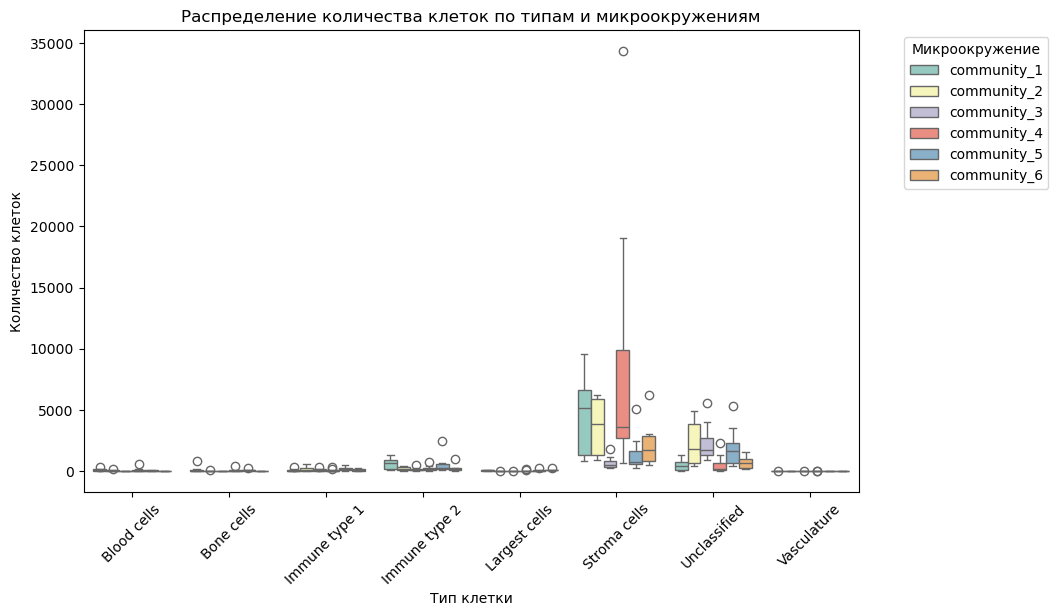

In [27]:
# Визуализация для наглядного сравнения количеств клеток разных типов в различных микроокружениях.

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell_type', y='cell_count', hue='cell_interaction', data=cell_counts, palette="Set3")
plt.title('Распределение количества клеток по типам и микроокружениям')
plt.xticks(rotation=45)
plt.ylabel('Количество клеток')
plt.xlabel('Тип клетки')
plt.legend(title='Микроокружение', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

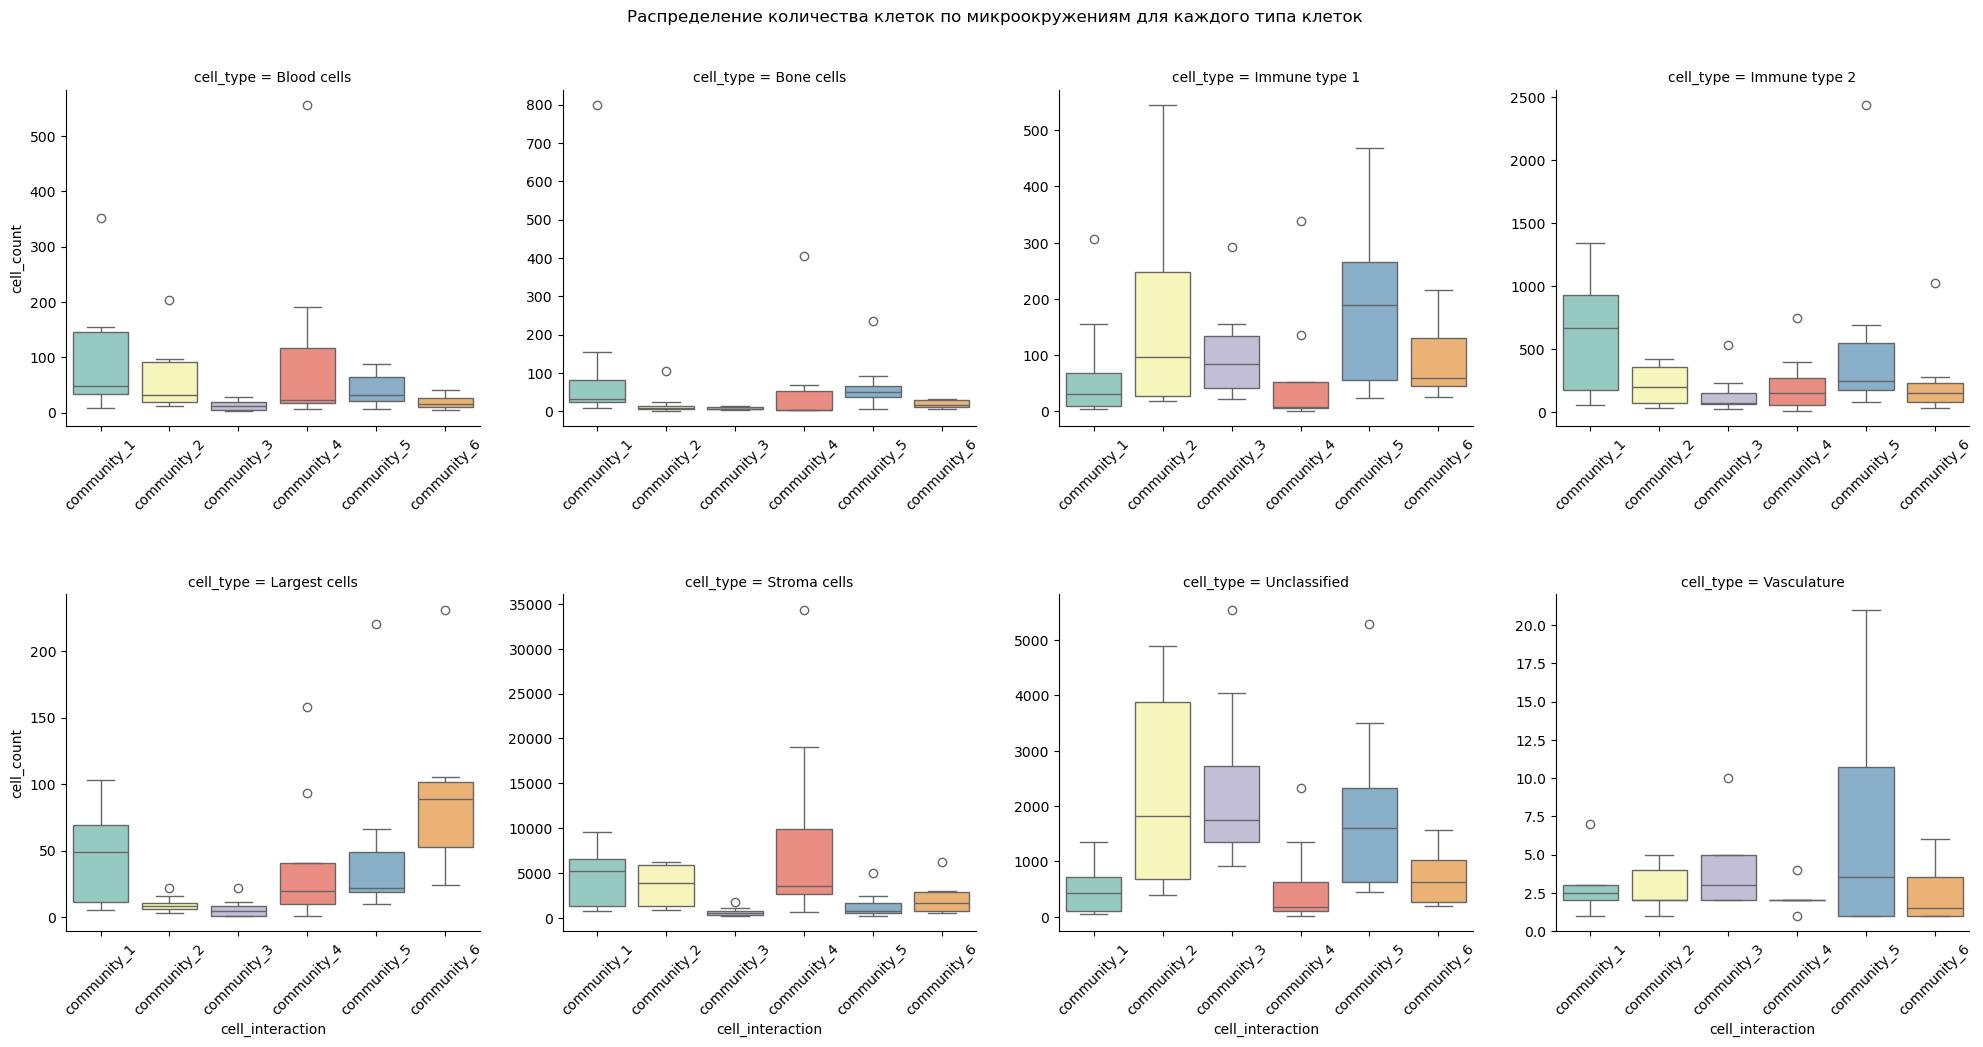

In [28]:
# Визуализируем данные на разных графиках (в разном масштабе оси Y)

import warnings
# Игнорируем конкретное предупреждение
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Использование FacetGrid для создания отдельных подграфиков для каждого типа клеток
g = sns.FacetGrid(cell_counts, col="cell_type", col_wrap=4, sharex=False, sharey=False, height=5, aspect=1)
g.map(sns.boxplot, "cell_interaction", "cell_count", palette="Set3")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Распределение количества клеток по микроокружениям для каждого типа клеток')
g.fig.subplots_adjust(hspace=0.5, wspace=0.2)

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

На основе предоставленного графика можно сделать выводы о том, в каких клеточных микроокружениях определенные типы клеток встречаются статистически чаще, чем в других микроокружениях. Однако, из-за ограниченности визуализации и отсутствия детального анализа каждого типа клеток в каждом микроокружении в этом текстовом ответе, важно учитывать, что выводы делаются на основе общего визуального восприятия графика.

* В некоторых типах клеток количество значительно варьируется в зависимости от микроокружения, что указывает на различное распределение клеток в разных микроокружениях.
* Для определенных типов клеток одни микроокружения представлены более широко, чем другие, что может указывать на их более значительную роль или преобладание в этих конкретных условиях.
Наличие выбросов в данных может указывать на пациентов с необычно высоким или низким количеством определенных типов клеток в конкретных микроокружениях.

    - Blood cells: наибольшее среднее количество в микроокружении community_4.
    - Bone cells: наибольшее среднее количество в микроокружении community_1.
    - Immune type 1: наибольшее среднее количество в микроокружении community_5.
    - Immune type 2: наибольшее среднее количество в микроокружении community_1.
    - Largest cells: наибольшее среднее количество в микроокружении community_6.
    - Stroma cells: наибольшее среднее количество в микроокружении community_4, причем существенно больше, чем для других типов клеток.
    - Unclassified: наибольшее среднее количество в микроокружении community_3.
    - Vasculature: наибольшее среднее количество в микроокружении community_5, хотя количество клеток этого типа относительно мало по сравнению с другими типами клеток.
 
Эти результаты показывают, как различные типы клеток распределяются по микроокружениям, указывая на потенциальную специализацию или предпочтительные условия для каждого типа клеток в рамках тканевой архитектуры плоскоклеточного рака. 

Подтвердим наблюдения, выполнив статистические тесты.

In [29]:
# Получение уникальных значений для типов клеток и микроокружений из исходных данных
cell_types = data['cell_type'].unique()
interactions = data['cell_interaction'].unique()

shapiro_results = {}

# Проводим тест Шапиро-Уилка для каждого сочетания типа клетки и микроокружения
for cell_type in cell_types:
    shapiro_results[cell_type] = {}
    for interaction in interactions:
        # Фильтруем данные по типу клетки и микроокружению
        sample = cell_counts[(cell_counts['cell_type'] == cell_type) &
                             (cell_counts['cell_interaction'] == interaction)]['cell_count']
        if len(sample) < 3:
            shapiro_results[cell_type][interaction] = {'Statistic': None, 'p-value': None}
            continue
        # Проведение теста Шапиро-Уилка и сохранение результатов
        stat, p = shapiro(sample)
        shapiro_results[cell_type][interaction] = {'Statistic': stat, 'p-value': p}

shapiro_results


{'Stroma cells': {'community_1': {'Statistic': 0.9097660344569579,
   'p-value': 0.3524189927955763},
  'community_2': {'Statistic': 0.8292313080199001,
   'p-value': 0.05828412534508902},
  'community_3': {'Statistic': 0.8190254493640095,
   'p-value': 0.04557536781106554},
  'community_4': {'Statistic': 0.7364495522357204,
   'p-value': 0.005778111296300989},
  'community_5': {'Statistic': 0.7365625996815145,
   'p-value': 0.005794879468078701},
  'community_6': {'Statistic': 0.8320325294433014,
   'p-value': 0.06232470521775679}},
 'Unclassified': {'community_1': {'Statistic': 0.906212517694101,
   'p-value': 0.3281620117885042},
  'community_2': {'Statistic': 0.8734253759863746,
   'p-value': 0.1627692569182504},
  'community_3': {'Statistic': 0.8352127283429794,
   'p-value': 0.06723451660192495},
  'community_4': {'Statistic': 0.7141680744492214,
   'p-value': 0.0032542671772290096},
  'community_5': {'Statistic': 0.8519421467008667,
   'p-value': 0.09967748640188362},
  'communi

В большинстве случаев данные не следуют нормальному распределению (p-значения меньше 0.05) => используем тест Красела-Уоллеса.

In [30]:
kruskal_results = {}

# Проводим тест Краскела-Уоллиса для каждого типа клеток
for cell_type in cell_types:
    # Фильтруем данные по типу клетки
    data_filtered = cell_counts[cell_counts['cell_type'] == cell_type]

    # Список для хранения выборок каждого микроокружения
    samples = []

    for interaction in interactions:
        # Выборка количества клеток для микроокружения и типа клетки
        sample = data_filtered[data_filtered['cell_interaction'] == interaction]['cell_count'].values
        samples.append(sample)

    # Проведение теста Краскела-Уоллиса и сохранение результатов
    stat, p = kruskal(*samples)
    kruskal_results[cell_type] = {'Statistic': stat, 'p-value': p}

kruskal_results

{'Stroma cells': {'Statistic': 18.727040816326507,
  'p-value': 0.0021605838372889432},
 'Unclassified': {'Statistic': 18.966836734693857,
  'p-value': 0.0019496673303232715},
 'Immune type 2': {'Statistic': 8.730539572250546,
  'p-value': 0.12030688182646924},
 'Blood cells': {'Statistic': 13.595872269911977,
  'p-value': 0.018390883472722126},
 'Bone cells': {'Statistic': 16.995067617636135,
  'p-value': 0.004509160881281219},
 'Largest cells': {'Statistic': 23.78865699222782,
  'p-value': 0.00023838374262455457},
 'Immune type 1': {'Statistic': 9.94262662179033,
  'p-value': 0.07687731356218432},
 'Vasculature': {'Statistic': 2.8982647496281704,
  'p-value': 0.7156668238597411}}

## Такии образом:

Есть статистически значимые различия в количестве клеток между микроокружениями для:
* Blood cells
* Bone cells
* Largest cells
* Stroma cells
* Unclassified

Нет статистически значимых различий в количестве клеток между микроокружениями для:
* Immune type 1
* Immune type 2
* Vasculature

## Задача 3

Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:

* по Ох будут микроокружения,
* по Оу — их доля в ткани пациента.

Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [32]:
# Подсчет общего количества клеток для каждого пациента
total_cells_per_patient = data.groupby(['case_id', 'age_group']).size().reset_index(name='total_cells')

# Подсчет количества клеток в каждом микроокружении для каждого пациента
cells_per_interaction = data.groupby(['case_id', 'age_group', 'cell_interaction']).size().reset_index(name='cells_in_interaction')

# Объединение данных для расчета доли микроокружения в ткани каждого пациента
interaction_proportions = pd.merge(cells_per_interaction, total_cells_per_patient, on=['case_id', 'age_group'])

# Расчет доли
interaction_proportions['proportion'] = interaction_proportions['cells_in_interaction'] / interaction_proportions['total_cells']

# Проверка результатов
interaction_proportions.head()


,case_id,age_group,cell_interaction,cells_in_interaction,total_cells,proportion
0,40,elder_group,community_1,7421,50062,0.148236
1,40,elder_group,community_2,7734,50062,0.154488
2,40,elder_group,community_3,8252,50062,0.164836
3,40,elder_group,community_4,3669,50062,0.073289
4,40,elder_group,community_5,13664,50062,0.272942


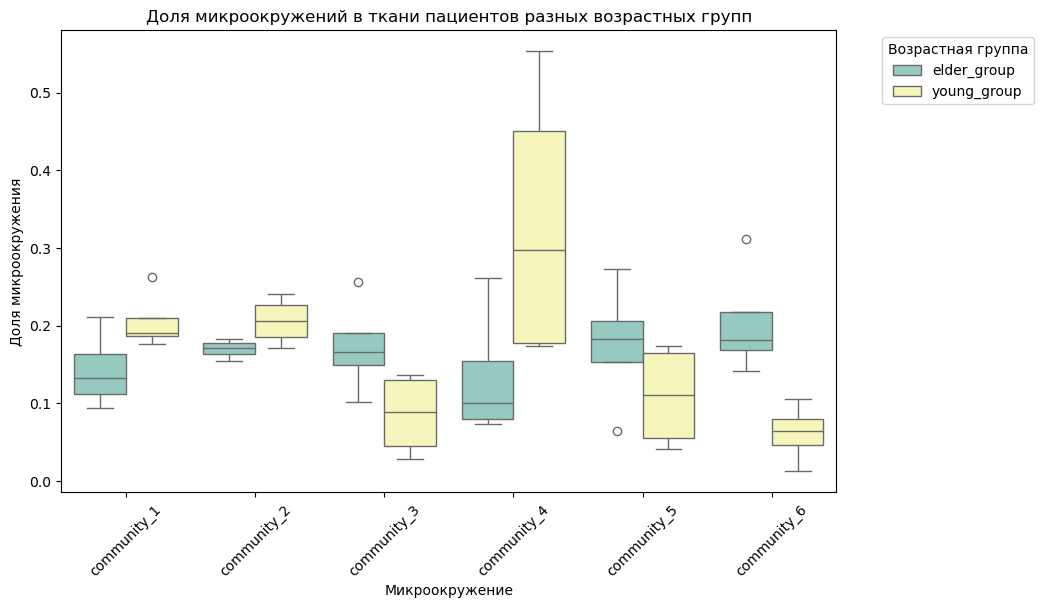

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cell_interaction', y='proportion', hue='age_group', data=interaction_proportions, palette="Set3")
plt.title('Доля микроокружений в ткани пациентов разных возрастных групп')
plt.xticks(rotation=45)
plt.ylabel('Доля микроокружения')
plt.xlabel('Микроокружение')
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [34]:
# проверим нормальность
shapiro_results_interaction = {}

# Проведем тест Шапиро-Уилка для каждого микроокружения в каждой возрастной группе
for interaction in interactions:
    shapiro_results_interaction[interaction] = {}
    for age_group in interaction_proportions['age_group'].unique():
        # Фильтруем данные по микроокружению и возрастной группе
        sample = interaction_proportions[(interaction_proportions['cell_interaction'] == interaction) &
                                          (interaction_proportions['age_group'] == age_group)]['proportion']
        # Если в выборке меньше 3 наблюдений, тест Шапиро-Уилка не может быть корректно применен
        if len(sample) < 3:
            shapiro_results_interaction[interaction][age_group] = {'Statistic': None, 'p-value': None}
            continue
        # Проведение теста Шапиро-Уилка и сохранение результатов
        stat, p = shapiro(sample)
        shapiro_results_interaction[interaction][age_group] = {'Statistic': stat, 'p-value': p}

shapiro_results_interaction

{'community_1': {'elder_group': {'Statistic': 0.9527967951028729,
   'p-value': 0.7336215682944546},
  'young_group': {'Statistic': 0.7853828305517215,
   'p-value': 0.07848643974452581}},
 'community_2': {'elder_group': {'Statistic': 0.9885564735216525,
   'p-value': 0.9499616437966465},
  'young_group': {'Statistic': 0.9604716121236062,
   'p-value': 0.7818765481470611}},
 'community_3': {'elder_group': {'Statistic': 0.9407047327189176,
   'p-value': 0.6586285827750271},
  'young_group': {'Statistic': 0.8607622974703613,
   'p-value': 0.2629507904307446}},
 'community_4': {'elder_group': {'Statistic': 0.8039244612371219,
   'p-value': 0.10944612901435274},
  'young_group': {'Statistic': 0.8621280996776257,
   'p-value': 0.2679004388631268}},
 'community_5': {'elder_group': {'Statistic': 0.9368296486114227,
   'p-value': 0.6350926224377991},
  'young_group': {'Statistic': 0.8379847740560014,
   'p-value': 0.1895916308103292}},
 'community_6': {'elder_group': {'Statistic': 0.8455356686

Результаты теста Шапиро-Уилка указывают на то, что распределение долей микроокружений в тканях пациентов разных возрастных групп в большинстве случаев нормальное или близкое к нормальному (Community_1-Young group, Community_4-Elder group, Community_5-Young group). В связи с этим для сравнения средних значений между возрастными группами предпочтительно использовать тест Манна-Уитни, чтобы определить наличие статистически значимых различий между группами, особенно в тех случаях, где распределение находится на границе нормальности.

In [35]:
from scipy.stats import mannwhitneyu

mannwhitney_results = {}

# Тест Манна-Уитни для каждого микроокружения
for interaction in interactions:
    mannwhitney_results[interaction] = {}
    # Данные для старшей возрастной группы
    elder_sample = interaction_proportions[(interaction_proportions['cell_interaction'] == interaction) &
                                           (interaction_proportions['age_group'] == 'elder_group')]['proportion']
    # Данные для младшей возрастной группы
    young_sample = interaction_proportions[(interaction_proportions['cell_interaction'] == interaction) &
                                           (interaction_proportions['age_group'] == 'young_group')]['proportion']
    # Проверка на достаточный размер выборки
    if len(elder_sample) > 0 and len(young_sample) > 0:
        # Проведение теста Манна-Уитни
        stat, p = mannwhitneyu(elder_sample, young_sample, alternative='two-sided')
        mannwhitney_results[interaction] = {'Statistic': stat, 'p-value': p}
    else:
        mannwhitney_results[interaction] = {'Statistic': None, 'p-value': None}

mannwhitney_results


{'community_1': {'Statistic': 3.0, 'p-value': 0.2},
 'community_2': {'Statistic': 2.0, 'p-value': 0.11428571428571428},
 'community_3': {'Statistic': 14.0, 'p-value': 0.11428571428571428},
 'community_4': {'Statistic': 2.0, 'p-value': 0.11428571428571428},
 'community_5': {'Statistic': 14.0, 'p-value': 0.11428571428571428},
 'community_6': {'Statistic': 16.0, 'p-value': 0.02857142857142857}}

## Таким образом:

Тест Манна-Уитни показал отсутствие статистически значимых различий в долях микроокружений между молодыми и пожилыми пациентами для всех микроокружений, кроме Community_6, где наблюдаются значимые различия (p=0.0286), указывая на возрастные изменения в этом микроокружении.

## Задача 4

Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

In [36]:
import numpy as np

def bootstrap_mean_difference(data1, data2, n_bootstrap=10000):
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        bootstrap_sample1 = np.random.choice(data1, size=len(data1), replace=True)
        bootstrap_sample2 = np.random.choice(data2, size=len(data2), replace=True)
        bootstrap_diff = np.mean(bootstrap_sample1) - np.mean(bootstrap_sample2)
        bootstrap_diffs.append(bootstrap_diff)
    return np.array(bootstrap_diffs)

# Фильтрация данных по типу клеток и возрастной группе
immune_young = data[(data['cell_type'].isin(['Immune type 1', 'Immune type 2'])) & (data['age_group'] == 'young_group')]
immune_elder = data[(data['cell_type'].isin(['Immune type 1', 'Immune type 2'])) & (data['age_group'] == 'elder_group')]
stroma_young = data[(data['cell_type'] == 'Stroma cells') & (data['age_group'] == 'young_group')]
stroma_elder = data[(data['cell_type'] == 'Stroma cells') & (data['age_group'] == 'elder_group')]

# Выполнение бутстрапа для оценки разницы средних расстояний до сосудов и крупных клеток
bootstrap_diffs_young_vasc = bootstrap_mean_difference(
    immune_young['distance_to_vasculature'].values, 
    stroma_young['distance_to_vasculature'].values
)

bootstrap_diffs_elder_vasc = bootstrap_mean_difference(
    immune_elder['distance_to_vasculature'].values, 
    stroma_elder['distance_to_vasculature'].values
)

bootstrap_diffs_young_largest = bootstrap_mean_difference(
    immune_young['distance_to_largest_cell'].values, 
    stroma_young['distance_to_largest_cell'].values
)

bootstrap_diffs_elder_largest = bootstrap_mean_difference(
    immune_elder['distance_to_largest_cell'].values, 
    stroma_elder['distance_to_largest_cell'].values
)

# Расчет 95% доверительного интервала для разницы средних
ci_95_young_vasc = np.percentile(bootstrap_diffs_young_vasc, [2.5, 97.5])
ci_95_elder_vasc = np.percentile(bootstrap_diffs_elder_vasc, [2.5, 97.5])
ci_95_young_largest = np.percentile(bootstrap_diffs_young_largest, [2.5, 97.5])
ci_95_elder_largest = np.percentile(bootstrap_diffs_elder_largest, [2.5, 97.5])

(ci_95_young_vasc, ci_95_elder_vasc, ci_95_young_largest, ci_95_elder_largest)


(array([-28.88864145, -20.22621361]),
 array([-31.46379215, -23.67729322]),
 array([-9.33720453, -4.47852435]),
 array([-23.07139951, -16.5869191 ]))

* Расстояние до сосудов
    - Молодые пациенты: 95% доверительный интервал для разницы средних расстояний между иммунными и стромальными клетками составляет от -28.9 до -20.2. Это указывает на то, что иммунные клетки в среднем находятся ближе к сосудам, чем стромальные клетки, при этом разница статистически значима, так как интервал не включает 0.
    - Пожилые пациенты: Доверительный интервал от -31.5 до -23.7 также указывает на близость иммунных клеток к сосудам по сравнению со стромальными клетками, с аналогичным статистическим значением различий.

* Расстояние до крупных клеток
    - Молодые пациенты: Доверительный интервал от -9.4 до -4.5 также свидетельствует о том, что иммунные клетки в среднем расположены ближе к крупным клеткам, чем стромальные клетки, с разницей статистически значимой.
    - Пожилые пациенты: Доверительный интервал от -23.0 до -16.6 указывает на аналогичную тенденцию близости иммунных клеток к крупным клеткам по сравнению со стромальными клетками, также с статистически значимыми различиями.


## Таким образом: 
Результаты указывают на то, что как для молодых, так и для пожилых пациентов, иммунные клетки (Immune type 1 и Immune type 2) статистически значимо располагаются ближе к сосудам и крупным клеткам, чем стромальные клетки. Таким образом, предположение о том, что это явление наблюдается только у молодых пациентов, но не у пожилых, не подтверждается: наблюдаемая тенденция сохраняется в обеих возрастных группах.

## Задача 5
Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью этого инструмента.

In [38]:
from scipy.stats import combine_pvalues

# Функция выолнения пермутационного теста
def run_permutation_test(means_by_patient, overall_distances, permutations=10000):
    num_patients = len(means_by_patient)
    exceed_counts = np.zeros(num_patients)  # Количество случаев, когда пермутированное среднее меньше исходного
    
    for _ in range(permutations):
        perm_means = [np.mean(np.random.choice(overall_distances, num_patients, replace=True)) for _ in range(num_patients)]
        exceed_counts += np.array(perm_means) < np.array(means_by_patient)  # Сравниваем с исходными средними

    perm_p_values = exceed_counts / permutations  # Вычисление p-значений
    return perm_p_values

# Подготовка данных по типам иммунных клеток и возрастным группам
imm_types = ['Immune type 1', 'Immune type 2']
young_group_means = data[(data['cell_type'].isin(imm_types)) & (data['age_group'] == 'young_group')].groupby('case_id')['distance_to_vasculature'].mean()
elder_group_means = data[(data['cell_type'].isin(imm_types)) & (data['age_group'] == 'elder_group')].groupby('case_id')['distance_to_vasculature'].mean()

# Все значения расстояний до сосудов
all_vascular_distances = data['distance_to_vasculature'].values

# Проведение анализа
young_p_values = run_permutation_test(young_group_means, all_vascular_distances)
elder_p_values = run_permutation_test(elder_group_means, all_vascular_distances)

# Комбинирование результатов
combined_result_young = combine_pvalues(young_p_values, method='fisher')
combined_result_elder = combine_pvalues(elder_p_values, method='fisher')

(combined_result_young, combined_result_elder)

(SignificanceResult(statistic=7.114914545743911, pvalue=0.5242866154630677),
 SignificanceResult(statistic=16.80970053108341, pvalue=0.03215279323495723))

* Для молодых пациентов:

Нет статистически значимых различий в среднем расстоянии до сосудов между иммунными клетками и остальными клетками в тканях молодых пациентов. P-значение выше установленного порога в 0.05, следовательно, нулевая гипотеза о равенстве расстояний не отвергается.

* Для пожилых пациентов:

Есть наличие статистически значимых различий в среднем расстоянии до сосудов между иммунными клетками и остальными клетками в тканях пожилых пациентов. P-значение ниже установленного порога, что позволяет отвергнуть нулевую гипотезу и принять альтернативную гипотезу о наличии различий.

## Таким образом:

Гипотеза о том, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов, не находит подтверждения. Результаты показывают, что значимых различий в расстояниях до сосудов для иммунных клеток среди молодых пациентов не обнаружено (p-value > 0.05), тогда как у пожилых пациентов такие различия присутствуют (p-value < 0.05). Следовательно, можно сделать вывод, что иммунные клетки находятся ближе к сосудам именно в тканях пожилых пациентов, что противоречит первоначальной гипотезе.